# INFO-600 Project Summary



##### By Christos Daoulas

In this project, I will implement a data processing pipeline to compute the driving habits of drivers in a pre-determined geographical zone. The data will consistent on information on the position on each driver, that is produced from a mobile phone's GPS coordinates. I will be using three files, "drivers.csv" (containing driver relevant location data), "zones.json" (containing information on the zones of the drivers) and "map.geojson" (containing a map of the zones and the driver positions). The Project will be using PySpark predominantly and is structured in two sections:

Section 1, where, given the positions of drivers and a list of different zones, geographic areas, I will find the ten zones that are visited by the most drivers. I will also write a few words on how Spark parallelizes the computation and propose some adjustments in order to make the current parallelization strategy more efficient.

Section 2, where I will perform more Data and Statistical Analyses in order to extract further insight from the data. In this section I will also identify the potential for further efficiency gains in my parallelization strategy where relevant.


# Section 1

I will start by installing a number of packages I will be using in my Data Analysis:

In [96]:
#Packages to be installed:

#import sys
#!{sys.executable} -m pip install shapely
#!{sys.executable} -m pip install geopandas
#!{sys.executable} -m pip install fiona



In [264]:
import os
import pandas as pd
from shapely.geometry import Point #pip install shapely
from shapely.geometry.polygon import Polygon
import pyspark.sql.functions as F
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import StringType, IntegerType
from pyspark.sql.functions import struct, col, desc, row_number, sum, when
from pyspark.sql.window import Window




os.environ['PYSPARK_SUBMIT_ARGS'] ="--conf spark.driver.memory=3g  pyspark-shell"


from pyspark.sql import SparkSession

try: 
    spark
    print("Spark application already started. Terminating existing application and starting new one")
    spark.stop()
except: 
    pass


spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("demoRDD") \
    .getOrCreate()
    
sc =spark.sparkContext


Spark application already started. Terminating existing application and starting new one


First I will proceed by loading my dataframes. Some information on both:



1. Drivers.csv

Each row of the CSV refers to one GPS measurement. The schema of the drivers data is the following:

• driver (String), the unique identifier of each driver

• Timestamp (Timestamp), the event creation time

• latitude (Double), the latitude geographic coordinate as received from GPS sensors

• longitude (Double), the longitude geographic coordinate as received from GPS sensors






2. Zones.csv

Each zone is described by a polygon and a unique identifier. A polygon is described by a counterclockwise sequence
of points (latitude - longitude pairs). The schema of the zones data is the following:

• id_zone (Long), the unique identifier of each zone

• polygon (Array of points), sequence of points (latitude - longitude pairs)

In [266]:
drivers = spark.read.csv('drivers.csv', header=True, inferSchema=True).cache()

zones = spark.read.json("zones.json",multiLine=True).cache()

I then create a new column using the struct built-in function, combining the columns latitude and longitude that will help further calculations. In order to help spark access the databases I will but them in a dual memory/disk cache which is also faultproof. I will follow this process for future big datasets requiring manipulation.

In [267]:
driverscomp = drivers.withColumn("coordinates",F.struct(drivers.latitude,drivers.longitude)).cache()

In [268]:
driverscomp.show(10)

+--------+-------------------+----------+----------+--------------------+
|  driver|          timestamp|  latitude| longitude|         coordinates|
+--------+-------------------+----------+----------+--------------------+
|c473205b|2017-08-31 14:24:25|-12.106778|-76.998078|{-12.106778, -76....|
|a0f3b4e1|2017-08-31 14:24:26|-12.103913|-76.963727|{-12.103913, -76....|
|1236f9fe|2017-08-31 14:24:26|-12.133777|-77.004266|{-12.133777, -77....|
|ae4a06a2|2017-08-31 14:24:26|-12.085963|-76.987582|{-12.085963, -76....|
|ab7a6c63|2017-08-31 14:24:26|-12.072973|-77.061448|{-12.072973, -77....|
|5ee73484|2017-08-31 14:24:26|-12.067694|-77.068442|{-12.067694, -77....|
|4fff90cb|2017-08-31 14:24:26|-12.144308|-76.989234|{-12.144308, -76....|
|d892d208|2017-08-31 14:24:26|-16.401221|-71.499513|{-16.401221, -71....|
|e9f90dfb|2017-08-31 14:24:10|-12.063665|-76.963254|{-12.063665, -76....|
|c1719f8d|2017-08-31 14:24:10|-12.070187|-76.994167|{-12.070187, -76....|
+--------+-------------------+--------

In [269]:
driverzone = driverscomp.select("driver","coordinates").cache()

In [270]:
driverzone.show(10)

+--------+--------------------+
|  driver|         coordinates|
+--------+--------------------+
|c473205b|{-12.106778, -76....|
|a0f3b4e1|{-12.103913, -76....|
|1236f9fe|{-12.133777, -77....|
|ae4a06a2|{-12.085963, -76....|
|ab7a6c63|{-12.072973, -77....|
|5ee73484|{-12.067694, -77....|
|4fff90cb|{-12.144308, -76....|
|d892d208|{-16.401221, -71....|
|e9f90dfb|{-12.063665, -76....|
|c1719f8d|{-12.070187, -76....|
+--------+--------------------+
only showing top 10 rows



I will use the driverzone dataframe as a basis to find the ten most frequented zones. The strategy I will follow is the following: a)extract the id's of all the zones from the zones json file; b) extract the coordinates for the polygons from the same file; c) create a function that will assign the location of each driver in the driverscomp dataframe to one of the these zones, or to "Null" if out of the zones; d) apply this UDF on the dataframe in order to create a new column with the assigned zones; e)I will then finally determine the ten most frequented zones.

In [271]:
zonesfull = zones.select("zones").collect()[0]['zones']

First I extract the id zones and polygoon coordinates list from the json.

In [272]:
polycoorslist=[]
id_zones=[]

for i in zonesfull:
    id = i[0]
    poly = i[1]
    id_zones.append(id)
    polycoorslist.append(poly)

Then I create a UDF function that I will later apply on the pyspark dataframe. UDF functions are important for parallelization as they improve effiency compared to using let's say, pandas

In [273]:
def inpolygoncheck(coordinate):
    coordinate = Point(coordinate) # turns point into readable format for geopandas polygons
    i=0
    position=0
    for poly in polycoorslist: #iterates all polygons in the list to check if the point pertains to one of them
        polygon = Polygon(poly)
        check1 = polygon.contains(coordinate)# checks if driver's position is in the polygon
        check2 = polygon.touches(coordinate)# check if driver's position lies on border of polygon 
        if check1==True or check2==True:  #if the position is in/or a polygon, then it is assigned to the equivalent polygon and it's id zone
            position = id_zones[i]
            return position
        i+=1        
    position=None  #if no polygons include the coordinate, it's Zone is determined as "Null"
    return position

udfzone = F.udf(lambda x: inpolygoncheck(x),StringType())

I then apply the udf on the driverscomp dataframe to create a new column with the zone each driver pertained to, the moment his/her GPS coordinates were registered. 

In [274]:
driverswithzone = driverscomp.withColumn("Zone",udfzone("coordinates")).drop("coordinates").cache()

In [275]:
driverswithzone.show(10)

+--------+-------------------+----------+----------+----+
|  driver|          timestamp|  latitude| longitude|Zone|
+--------+-------------------+----------+----------+----+
|c473205b|2017-08-31 14:24:25|-12.106778|-76.998078|  21|
|a0f3b4e1|2017-08-31 14:24:26|-12.103913|-76.963727|  21|
|1236f9fe|2017-08-31 14:24:26|-12.133777|-77.004266|  14|
|ae4a06a2|2017-08-31 14:24:26|-12.085963|-76.987582|  21|
|ab7a6c63|2017-08-31 14:24:26|-12.072973|-77.061448|  22|
|5ee73484|2017-08-31 14:24:26|-12.067694|-77.068442|  22|
|4fff90cb|2017-08-31 14:24:26|-12.144308|-76.989234|  14|
|d892d208|2017-08-31 14:24:26|-16.401221|-71.499513|null|
|e9f90dfb|2017-08-31 14:24:10|-12.063665|-76.963254|  21|
|c1719f8d|2017-08-31 14:24:10|-12.070187|-76.994167|  21|
+--------+-------------------+----------+----------+----+
only showing top 10 rows



Finally we group the driverswithzone dataframe by "Zone", count each driver instance in that zone and then sort the resulting column "count" by descending order.

In [276]:
top10zones = driverswithzone.groupby("Zone").count().sort(desc("count")).show(10)

+----+-------+
|Zone|  count|
+----+-------+
|  22|1956633|
|  21|1015721|
|  14| 299026|
|  25| 233601|
|  13| 146840|
|null| 129870|
|  20|  73311|
|  23|  54902|
|  24|  48298|
|  26|  46378|
+----+-------+
only showing top 10 rows



We can see that the most popular zone is 22, followed by 21,14, 25 and 13 in the top 5. We also have many null values: 129870 to be exact. The sixth most popular "Zone" is the null one. The reason we have these null values, can be either because at the time, drivers were indeed positioned outside the area designated by the zones as they were leaving the city in question, or even due to other data collection errors such as GPS jittering. 

### Parallelization Strategy

Apache Spark is defined as a unified analytics engine destined for large-scale data processing. It writes directly to memory  instead of writing to slower drives as other computation processing engines. In addition, the data stored in Random Access Memory is processed in parallel.

In Spark, parallelization means that concurrent tasks may be running on the driver node or worker nodes. The way that each task is performed (or split) across different nodes in the same cluster is a function of the different data types and relevant tools used. 



One of the ways we have used to natively scale data processing in this section is harnessing the power of Spark Dataframes. In general, Pandas are not as fast as Spark Dataframes in handling big data and as such it is best to avoid passing high frequency data from more than one variables into Pandas. Instead, we used interfaces such as spark.read to directly load data sources into Spark data frames. apart from already setting some specific values for threads and resources to preemptively tackle performance issues. In order to make sure that we did not repeat unecessary calculations of the same dataframe we have also included the ".cache()" optimization technique, in order to reuse resources and not degrade performance.

It is noteworthy that we have also resulted to user defined functions (UDFs) that enable parallel processing by partitioning a Spark Dataframe (in this case "driverswithzone") into smaller data sets that are distributed according to the preceding paragraph and converted to Pandas objects, followed by the combination of their results to one large Spark Dataframe; in this way we get the combined advantages of parallelization and distribution.

In order to further increase efficiency we can consider tweaking some parameters of Spark Applications.

# Question 2

To have a better idea of the parameters in the current parallelization strategy, we can take a look at the output of sc._conf.getAll() below 

In [269]:
sc._conf.getAll()

[('spark.driver.port', '62044'),
 ('spark.driver.memory', '4g'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.warehouse.dir',
  'file:/C:/Users/cdaou/OneDrive/Documents/MSBDGA/INFO-600/PROJECT/INFO-600_Project/spark-warehouse'),
 ('spark.driver.host', 'LAPTOP-G864DOI1.home'),
 ('spark.app.startTime', '1642416339774'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.id', 'local-1642416343038'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'demoRDD')]

To incease efficiency we will start by changing some key parameters in the Spark Applications

In [214]:
os.environ['PYSPARK_SUBMIT_ARGS'] ="--conf spark.driver.memory=4g  pyspark-shell"


from pyspark.sql import SparkSession

try: 
    spark
    print("Spark application already started. Terminating existing application and starting new one")
    spark.stop()
except: 
    pass


spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("demoRDD") \
    .getOrCreate()
    
conf = SparkConf().setAppName("application").set("spark.executor.heartbeatInterval", "200000").set("spark.network.timeout", "700").set("spark.sql.broadcastTimeout", "1200")

sc =spark.sparkContext.getOrCreate(conf)

sc._conf.getAll()

Spark application already started. Terminating existing application and starting new one


[('spark.driver.memory', '4g'),
 ('spark.executor.id', 'driver'),
 ('spark.app.id', 'local-1642687920761'),
 ('spark.app.startTime', '1642687920641'),
 ('spark.sql.warehouse.dir',
  'file:/C:/Users/cdaou/OneDrive/Documents/MSBDGA/INFO-600/PROJECT/INFO-600_Project/spark-warehouse'),
 ('spark.driver.host', 'LAPTOP-G864DOI1.home'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '60590'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'demoRDD')]

As we can see, currently we are running as many threads as there are processors available to the Java virtual machine, by using local [ * ]. In addition we can see that we increased driver memory by 1GB to 4GB and also set spark.executor.heartbeatInterval and spark.network.timeout values. Heartbeats can impact performance as they let the driver know that the executor is still running and can receive metrics for in-progress tasks. It is worth noting that the spark.network.timeout should also be considerably large in order to allow for enough time to check for the progress of executors and stop early cessation of processes.

### Some further exploratory Data Analysis and Statistics

Before we proceed, it would be very interesting to visualise the map. Visualisation is always a fundamental element of a data scientist's toolkit, as it helps identify bottlenecks that had not been previously acknowledged by raw data analysis. Graphs and maps are very useful in this respect and we will map the coordinates in order to help guide our deep analysis of the data, through more informed and demonstrative storytelling.

We can have a better idea of the overview of zones and their positions, including null values, in the following maps. But first we will have to reverse the coordinates in the polygons of polycoorslist to match the proper mapping format

In [277]:
polycoorslist_r = []

for poly in polycoorslist:
    for p in poly:
        pi=p[::-1]
        polycoorslist_r.append(pi)
        
polycoorslist_rs= [polycoorslist_r[i:i + 5] for i in range(0, len(polycoorslist_r), 5)]        

We then extract the latitude and longitude values from each driver from the driverscomp dataframe. We will use these lists as inputs for an initial scatter plot

In [278]:
lat = driverscomp.select("latitude").collect()
long = driverscomp.select("longitude").collect()

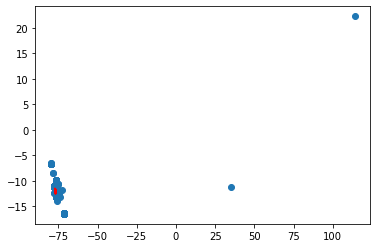

In [279]:
import matplotlib.pyplot as plt

for poly in polycoorslist_rs:
    polygon1 = Polygon(poly)
    x, y = polygon1.exterior.xy
    plt.plot(x, y, c="red")

plt.scatter(long,lat)
plt.show()

The blue points are the coordinates and the red colours refer to the wireframe of the zones. We see that a number of positions are outliers, that can impact the results of the analysis. As such we will try to limit latitude and longitude to negative values:

In [280]:
drc=driverscomp.filter("latitude < 0")
drc = drc.filter("longitude< 0")

In [281]:
lat2 = drc.select("latitude").collect()
long2 = drc.select("longitude").collect()

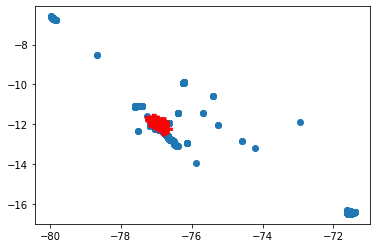

In [282]:
for poly in polycoorslist_rs:
    polygon1 = Polygon(poly)
    x, y = polygon1.exterior.xy
    plt.plot(x, y, c="red")

plt.scatter(long2,lat2 )
plt.show()

This threshold to deal with outliers indeed worked and focused the analysis area to a better degree. It is now evident that the majority of outliers pertain to coordinates of null Zones. If we disconsider the 129870 null values which are skewing the results, we have the following graph:

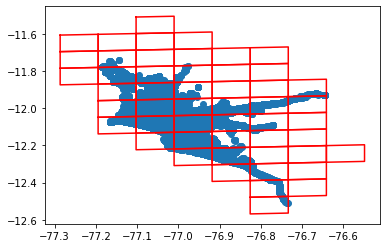

In [283]:
drc=driverswithzone.na.fill(value=0)
drc=drc.filter("Zone>0")

lat2 = drc.select("latitude").collect()
long2 = drc.select("longitude").collect()

for poly in polycoorslist_rs:
    polygon1 = Polygon(poly)
    x, y = polygon1.exterior.xy
    plt.plot(x, y, c="red")

plt.scatter(long2,lat2)
plt.show()

Much better! Taking a closer look, we also notice something important: indeed, we can see a total of 22 zones do not have any drivers traversing them! We can verify the number as well as the identity of these zones as below:

In [284]:
distinctzones = driverswithzone.select("Zone").distinct().collect()

In [285]:
dz = []

for i in distinctzones:
    if i[0] is not None:
        id = int(i[0])
        dz.append(id)


In [286]:
print("Zones not traversed: ",set(id_zones) - set(dz))
print("Number of non-traversed Zones: ",len(set(id_zones) - set(dz)))

Zones not traversed:  {1, 3, 4, 5, 6, 9, 10, 32, 33, 34, 36, 39, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51}
Number of non-traversed Zones:  22


As to where the points pertain?

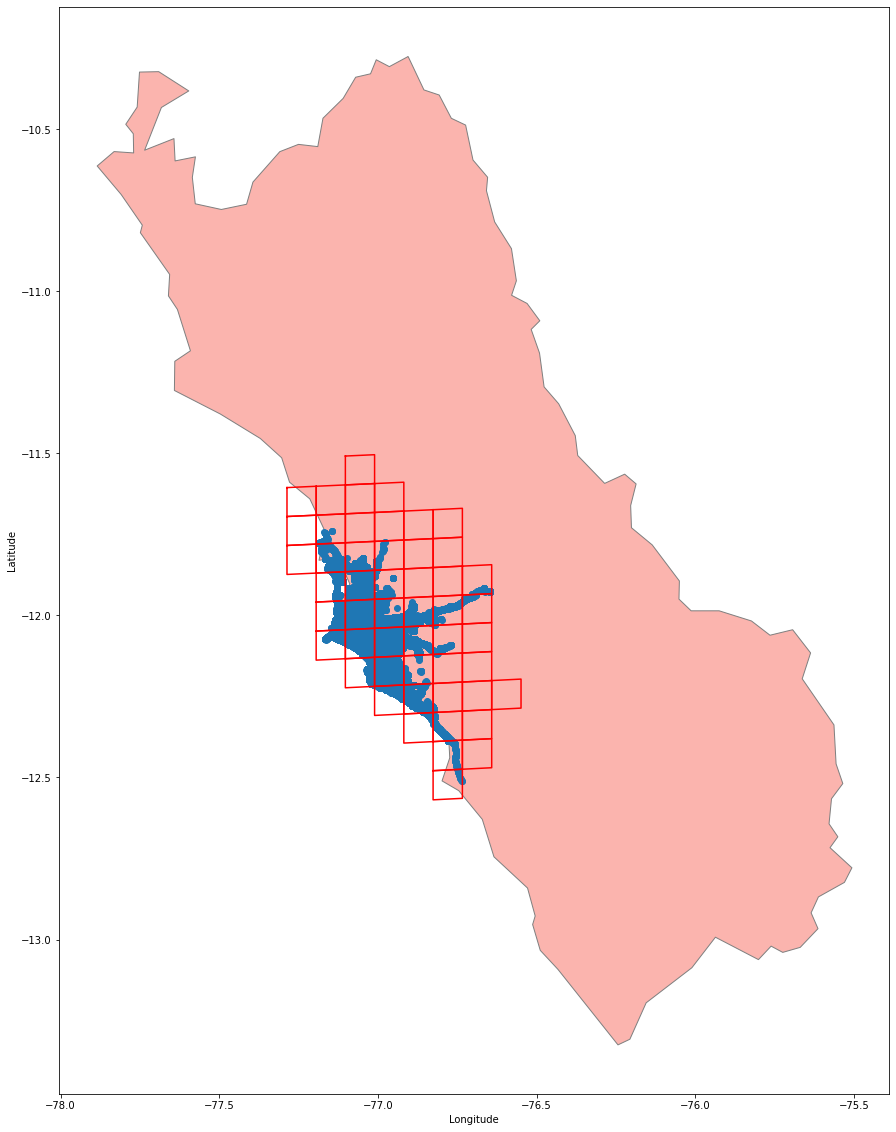

In [287]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import json, requests 
import urllib



region_geojson = gpd.read_file("map.geojson")



ax = region_geojson[region_geojson.NOMBDEP=='LIMA'].plot(figsize=(20,20),edgecolor=u'gray', cmap='Pastel1')

plt.scatter(long2, lat2)

for poly in polycoorslist_rs:
    polygon1 = Polygon(poly)
    x, y = polygon1.exterior.xy
    plt.plot(x, y, c="red")

plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()


 Why Peru, Lima district of course!

Let's now extract some more information on the drivers themselves. First, it is interesting noting whether all these points refer to different, or unique drivers, or the same drivers whose position has been taken in different points in time.

In [288]:
alldrivers=driverswithzone.select("driver").rdd.map(lambda x: 1).reduce(lambda a,b: a+b)

print("Number of all drivers: ", alldrivers)

Number of all drivers:  4079631


In [292]:
distinctdrivers=driverswithzone.select("driver").rdd.distinct().map(lambda x: 1).reduce(lambda a,b: a+b)

print("Number of distinct drivers: ", distinctdrivers)

Number of distinct drivers:  14652


It thus becomes obvious that we have the same set of drivers that traverse the zones. Who are the most popular urban explorers?

In [293]:
bestdrivers=driverswithzone.groupby("driver").count().sort(desc("count"))

In [294]:
bestdrivers.show()

+--------+-----+
|  driver|count|
+--------+-----+
|a9f2d2f0| 1011|
|0a6c6091|  941|
|5a099f58|  845|
|ede5b55b|  831|
|09fff8d8|  825|
|9ec990d0|  821|
|53c75585|  818|
|a7c4b5a1|  813|
|e55c5e16|  812|
|7dc5991a|  810|
|39298afb|  810|
|ce0ba2e2|  809|
|f9091fb5|  806|
|ee110a9e|  802|
|bea0d8f3|  801|
|c5b3d5a6|  801|
|af2dc1b8|  799|
|fb6bddfa|  798|
|0e653759|  797|
|dcaf0ba6|  797|
+--------+-----+
only showing top 20 rows



We can see that a9f2d2f0 is the most common driver, closely followed by 0a6c6091 and 5a099f58

Is there a relationship between popularity and zones visited? In other words, have the most popular drivers also visited the most zones? In this case we would have to aggregate all the zones each driver has visited. The best way to do that would be to create a pivot table, where each driver and his/her counts would be used as an identifier, and then a column for each of the zones traversed would be used to calculate how many instances of each drivers' locations fall within these zones. We also sort by descending to get the proper counts.

In [296]:
mostzones = driverswithzone.groupBy("driver","Zone").count().sort(desc("count"))
mostzonespivot = mostzones.groupby("driver","Count").pivot("Zone").sum().sort(desc("count")).cache()

We can then visualize the data:

In [297]:
mostzonespivot.show(100, truncate = False)

+--------+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|driver  |Count|null|11  |12  |13  |14  |15  |16  |17  |18  |19  |2   |20  |21  |22  |23  |24  |25  |26  |27  |28  |29  |30  |31  |35  |37  |38  |40  |49  |7   |8   |
+--------+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|ce0ba2e2|803  |null|null|null|null|null|null|null|null|null|null|null|null|null|803 |null|null|null|null|null|null|null|null|null|null|null|null|null|null|null|null|
|a9f2d2f0|781  |null|null|null|null|null|null|null|null|null|null|null|null|781 |null|null|null|null|null|null|null|null|null|null|null|null|null|null|null|null|null|
|28941a0f|778  |778 |null|null|null|null|null|null|null|null|null|null|null|null|null|null|null|null|null|null|null|null|null|null|null|null|null|null|null|null|null

Hmm, too many null values. Let's make it easier to read by substituting null values for zeros:

In [298]:
df = mostzonespivot.na.fill(value=0).cache()
df.show()

+--------+-----+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|  driver|Count|null| 11| 12| 13| 14| 15| 16| 17| 18| 19|  2| 20| 21| 22| 23| 24| 25| 26| 27| 28| 29| 30| 31| 35| 37| 38| 40| 49|  7|  8|
+--------+-----+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|ce0ba2e2|  803|   0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|803|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|
|a9f2d2f0|  781|   0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|781|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|
|28941a0f|  778| 778|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|
|fb6bddfa|  765|   0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|765|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|
|8abfed1a|  759| 759|  0|  0|  0| 

In [322]:
df.groupby("driver").sum().sort(desc("sum(Count)")).show()

+--------+----------+---------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+
|  driver|sum(Count)|sum(null)|sum(11)|sum(12)|sum(13)|sum(14)|sum(15)|sum(16)|sum(17)|sum(18)|sum(19)|sum(2)|sum(20)|sum(21)|sum(22)|sum(23)|sum(24)|sum(25)|sum(26)|sum(27)|sum(28)|sum(29)|sum(30)|sum(31)|sum(35)|sum(37)|sum(38)|sum(40)|sum(49)|sum(7)|sum(8)|
+--------+----------+---------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+
|a9f2d2f0|      1011|        0|      0|      0|      0|      0|      0|      0|      0|      0|      0|     0|      0|    781|    158|      0|     62|     10|      0|      0|      0|      0|      0|      0|      0|   

Better. We can now see all the zones traversed by each driver. An interesting trend appears by taking a look at the first 20 instances: we see that some drivers were in more than one zones. To specify further we cna create our own function. It will count non zero instances by row and ascribe the instances to the zone they belong two, by capturing the title of their respective column.

In [337]:
pivotzones = df.groupby("driver").sum().sort(desc("sum(Count)"))

def distinct_zones(df):
    
    zones = []
    distincts = []
    counts = []
    zonesf = []

    for row in df.rdd.toLocalIterator():
        eachrow  = row[2:]
        #print(eachrow)        
        distinct = [i for i, element in enumerate(eachrow) if element!=0 ]
        distincts.append(distinct)

        zonei=[]
        for element in distinct:
            
            index = element + 2
            zone = df.columns[index]
            #print(zone)
            zonei.append(zone)
        
        zones.append(zonei)
    
        
    
#        for z in zones:
 #           z = ', '.join(z)
  #          zonesf.append(z)

            
    for element in zones:
        count = len(element)
        counts.append(count)
        
    return zones,counts

distinct_zones(pivotzones)

([['sum(21)', 'sum(22)', 'sum(24)', 'sum(25)'],
  ['sum(13)', 'sum(22)', 'sum(24)', 'sum(25)'],
  ['sum(13)', 'sum(21)', 'sum(22)'],
  ['sum(13)', 'sum(14)', 'sum(21)', 'sum(22)'],
  ['sum(13)', 'sum(14)', 'sum(21)', 'sum(22)', 'sum(23)'],
  ['sum(13)', 'sum(14)', 'sum(21)', 'sum(22)'],
  ['sum(13)', 'sum(21)', 'sum(22)'],
  ['sum(21)', 'sum(22)'],
  ['sum(20)', 'sum(21)', 'sum(22)', 'sum(25)'],
  ['sum(13)', 'sum(14)', 'sum(15)', 'sum(21)', 'sum(22)'],
  ['sum(21)', 'sum(22)'],
  ['sum(13)', 'sum(14)', 'sum(21)', 'sum(22)'],
  ['sum(13)', 'sum(14)', 'sum(21)', 'sum(22)', 'sum(25)'],
  ['sum(13)', 'sum(14)', 'sum(20)', 'sum(21)', 'sum(22)', 'sum(25)'],
  ['sum(13)', 'sum(21)', 'sum(22)'],
  ['sum(13)', 'sum(14)', 'sum(21)', 'sum(22)'],
  ['sum(14)', 'sum(21)', 'sum(22)'],
  ['sum(13)', 'sum(22)'],
  ['sum(13)', 'sum(21)', 'sum(22)'],
  ['sum(21)', 'sum(22)'],
  ['sum(13)', 'sum(14)', 'sum(21)', 'sum(22)'],
  ['sum(13)', 'sum(14)', 'sum(19)', 'sum(20)', 'sum(21)', 'sum(22)'],
  ['sum(13

In [335]:
ids = []

for i in pivotzones.select("driver").collect():
    id = i[0]
    ids.append(id)
    

In [344]:
data=[ids,distinct_zones(pivotzones)]
data = {"id": data[0], "Zones": data[1][0], "Number_of_Zones": data[1][1]}


In [346]:
distinctzones = spark.createDataFrame(pd.DataFrame.from_dict(data))
distinctzones.show(truncate=False)

+--------+------------------------------------------------------+---------------+
|id      |Zones                                                 |Number_of_Zones|
+--------+------------------------------------------------------+---------------+
|a9f2d2f0|[sum(21), sum(22), sum(24), sum(25)]                  |4              |
|0a6c6091|[sum(13), sum(22), sum(24), sum(25)]                  |4              |
|5a099f58|[sum(13), sum(21), sum(22)]                           |3              |
|ede5b55b|[sum(13), sum(14), sum(21), sum(22)]                  |4              |
|09fff8d8|[sum(13), sum(14), sum(21), sum(22), sum(23)]         |5              |
|9ec990d0|[sum(13), sum(14), sum(21), sum(22)]                  |4              |
|53c75585|[sum(13), sum(21), sum(22)]                           |3              |
|a7c4b5a1|[sum(21), sum(22)]                                    |2              |
|e55c5e16|[sum(20), sum(21), sum(22), sum(25)]                  |4              |
|7dc5991a|[sum(1

In [348]:
distinctzones.sort(desc("Number_of_Zones")).show(truncate = False)

+--------+------------------------------------------------------------------------------------------+---------------+
|id      |Zones                                                                                     |Number_of_Zones|
+--------+------------------------------------------------------------------------------------------+---------------+
|8389457b|[sum(20), sum(21), sum(22), sum(24), sum(25), sum(26), sum(27), sum(28), sum(29), sum(49)]|10             |
|65c0dd20|[sum(13), sum(14), sum(15), sum(20), sum(21), sum(22), sum(23), sum(24), sum(25)]         |9              |
|90ff4328|[sum(19), sum(20), sum(21), sum(22), sum(25), sum(26), sum(35), sum(37), sum(40)]         |9              |
|ecdcfa9e|[sum(11), sum(12), sum(13), sum(14), sum(15), sum(16), sum(21), sum(22), sum(8)]          |9              |
|51e905b7|[sum(14), sum(19), sum(20), sum(21), sum(22), sum(23), sum(24), sum(25), sum(26)]         |9              |
|38d9996d|[sum(null), sum(11), sum(12), sum(13), sum(14)

Finally, we see that the most adventurous driver is "8389457b", with a total of 10 zones, followed by "65c0dd20" and "90ff4328" with 9 zones each. We can thus safely say that there is not necessarily a relationship between popularity and zones visited for the drivers evaluated.

Some more relevant statistics would be the modes of the most important variables in question, these being the drivers and their traversed zones being qualitative ones. We can start with the mode of the Zones.

In [349]:
modezone = driverswithzone.select("Zone").collect()

In [350]:
from statistics import mode
mode(modezone)

Row(Zone='22')

We see that the mode of the Zone column is 22, which is not very surprising given that Zone 22 is the most frequented zone. We then proceed with the mode of the driver:

In [351]:
mode(driverswithzone.select("driver").collect())

Row(driver='a9f2d2f0')

Again, not a very surprising result, as the driver in question is the one with the most coordinates. Finally, given the quantitative nature of the variable "Number_of_Zones" we can apply more comprehensive statistics

In [355]:
print(distinctzones.describe("Number_of_Zones").show())
print(mode(distinctzones.select("Number_of_Zones").collect()))

+-------+------------------+
|summary|   Number_of_Zones|
+-------+------------------+
|  count|             14652|
|   mean| 2.503412503412503|
| stddev|1.3089640013632988|
|    min|                 1|
|    max|                10|
+-------+------------------+

None
Row(Number_of_Zones=2)


We see that the minimum number of zones traversed is 1, with the maximum being 10 as demonstrated earlier. It is also interesting to see that the mean is between 2 and 3 which coincides with the mode of two zones being traversed as the mode. 

On terms of statistics we can also see if there are any points that have been traversed more than once, as well as which are the most frequented points

In [260]:
coorsu = driverzone.select("coordinates").distinct().count()
coorsa = driverzone.select("coordinates").count()

In [356]:
samepoints = coorsa - coorsu
print(samepoints)

878213


We see that there is an overlap of 878213 drivers, something that is expected in a very crowded city! Out of curiosity, which would those very popular points be?

In [361]:
driverscomp.groupby("coordinates").count().sort(desc("count")).show(truncate = False)

+------------------------+-----+
|coordinates             |count|
+------------------------+-----+
|{-12.021671, -77.108292}|2240 |
|{-12.022038, -77.108075}|1646 |
|{-12.02171, -77.1082}   |1132 |
|{-12.02171, -77.108201} |743  |
|{-12.023509, -77.10739} |552  |
|{-12.0235, -77.10738}   |548  |
|{-12.021671, -77.10829} |373  |
|{-12.10552, -76.989826} |325  |
|{-12.021943, -77.108332}|294  |
|{-12.045146, -76.98014} |293  |
|{-12.021938, -77.108111}|281  |
|{-12.109392, -76.87099} |256  |
|{-12.063676, -76.939564}|250  |
|{-12.021702, -77.108187}|244  |
|{-12.022037, -77.108075}|244  |
|{-12.202798, -76.976229}|243  |
|{-12.120085, -77.040977}|238  |
|{-12.022051, -77.108108}|237  |
|{-11.958421, -77.006483}|230  |
|{-12.0235, -77.107379}  |230  |
+------------------------+-----+
only showing top 20 rows



We see that the top 7 coordinates are situated in the Airport (Not surprisingly, as Peru is a beautiful country with many tourists, so the drivers are probably taxis or work for uber)

<img src="https://th.bing.com/th/id/R.a4365494a7a4dc640bdbd20a818f9d86?rik=BesbnMaGtoZm%2fw&pid=ImgRaw&r=0"/>

Finally, we can also introduce a time dimension in the above analysis. Two salient questions would be, which time of the day has the most drivers, which time of the day is popular by Zone amongst others.

In [376]:
from pyspark.sql.functions import hour, mean

timedzones = driverswithzone.groupby(hour("timestamp").alias("hour")).count().sort(desc("count")).show()


+----+------+
|hour| count|
+----+------+
|  16|922947|
|  17|892311|
|  18|849071|
|  15|820961|
|  14|594341|
+----+------+



We can easily see that 4pm is when the most drivers are on the road, which would make sense given that it is when they start leaving their jobs. As for which times of the day most frequented in the more popular Zones:

In [377]:
timedzones = driverswithzone.groupby("Zone",hour("timestamp").alias("hour")).count().sort(desc("count")).show()

+----+----+------+
|Zone|hour| count|
+----+----+------+
|  22|  16|476682|
|  22|  17|442589|
|  22|  18|403781|
|  22|  15|393746|
|  22|  14|239835|
|  21|  16|229580|
|  21|  17|223959|
|  21|  18|207569|
|  21|  15|198076|
|  21|  14|156537|
|  14|  18| 67128|
|  14|  17| 62727|
|  14|  15| 60307|
|  14|  14| 55823|
|  14|  16| 53041|
|  25|  15| 51627|
|  25|  14| 48422|
|  25|  18| 47731|
|  25|  17| 44213|
|  25|  16| 41608|
+----+----+------+
only showing top 20 rows



For Zone 22 it is 4,5,6 pm, for Zone 21 it is also 4,5,6pm whereas for zone 14, 6pm is the most frequented hour.

We can also see which Zone has the most time spent by a single driver

In [385]:
from pyspark.sql.functions import *

transform_expr = "transform(ts_array, (x,i) -> (unix_timestamp(ts_array[i+1]) - unix_timestamp(x))/60 * ((i+1)%2))"

zonesintime=driverswithzone.groupBy("driver", "Zone").agg(array_sort(collect_list(col("timestamp"))).alias("ts_array")) \
    .withColumn("transformed_ts_array", expr(transform_expr)) \
    .withColumn("Dur_Mins", expr("aggregate(transformed_ts_array, 0D, (acc, x) -> acc + coalesce(x, 0D))")) \
    .drop("transformed_ts_array", "ts_array") \
    .sort(desc("Dur_Mins"))

display(zonesintime.show(truncate=False), bestdrivers.show())

+--------+----+------------------+
|driver  |Zone|Dur_Mins          |
+--------+----+------------------+
|e2ca53e9|21  |294.5833333333333 |
|3f96ad72|14  |294.38333333333327|
|f4285082|25  |292.1             |
|3eaf4dcc|25  |292.05            |
|b0dfbb4a|14  |292.0166666666667 |
|746f9e9d|14  |290.9333333333333 |
|75493ced|13  |290.6833333333335 |
|0e5dbf6a|22  |290.30000000000007|
|c0372aac|25  |290.0833333333333 |
|0448378f|21  |289.1             |
|1461afb9|14  |288.9333333333334 |
|2bf48674|21  |288.5833333333334 |
|f6b64414|21  |285.0666666666667 |
|c82bf352|22  |284.55            |
|6b970e30|21  |283.23333333333335|
|fd482b3e|25  |282.76666666666665|
|af3239b4|13  |282.4333333333334 |
|b0b75777|21  |280.85            |
|0d08ebdb|14  |279.7166666666667 |
|8d4f5bec|22  |277.85            |
+--------+----+------------------+
only showing top 20 rows

+--------+-----+
|  driver|count|
+--------+-----+
|a9f2d2f0| 1011|
|0a6c6091|  941|
|5a099f58|  845|
|ede5b55b|  831|
|09fff8d8|  825

None

None

That Zone would be number 21 with driver e2ca53e9 for 258,58 mins. As for which driver spent the most time on the road:

In [392]:
zonesintime.groupby("driver").sum().sort(desc("sum(Dur_Mins)")).show()

+--------+-----------------+
|  driver|    sum(Dur_Mins)|
+--------+-----------------+
|467d507a|768.5833333333334|
|3f96ad72|694.6499999999997|
|31b8dbe5|652.0499999999998|
|dd2ecaaa|635.1666666666666|
|9d627e2c|620.1499999999999|
|e8c995a8|616.0333333333332|
|f6b64414|611.7166666666667|
|06668f5e|605.7666666666668|
|9cbebd67|602.4666666666665|
|384d1754|599.2666666666665|
|da6913e6|597.9499999999998|
|ef0e9191|595.1500000000001|
|3899bac9|593.0999999999999|
|00920923|584.9833333333333|
|023efa33|559.8833333333333|
|62724ae8|559.7833333333333|
|3c94a109|546.8833333333332|
|d0b81735|            545.9|
|8a3a13f8|540.7166666666664|
|f4285082|540.2333333333332|
+--------+-----------------+
only showing top 20 rows



That would be driver 467d507a for a whopping 768.5833333333334 minutes! Talk about being a hard worker. It becomes evident that driver popularity on terms of registration in the GPS coordinate database is not necessarilly equal to amount of time worked; a popular driver may work less time but register more GPS coordinates in the system. Out of curiosity, lets take a closer look at the most popular driver, a9f2d2f0 with 1011 registered GPS coordinates in 4 Zones

In [404]:
zonesintime.filter(zonesintime.driver == "a9f2d2f0").groupby("driver").sum().show()

+--------+------------------+
|  driver|     sum(Dur_Mins)|
+--------+------------------+
|a9f2d2f0|100.93333333333362|
+--------+------------------+



Indeed, (s)he registered these movements in an hour and a half, pretty fast.

# Conclusion

In this project we analysed the position of drivers by transforming dataframes containing data on their coordinates and zones, and extracted some interesting insights on terms of Zone popularity, frequency according to the time dimension, as well as comparison of movements between drivers. 

We also assessed the parallelization strategy and improved efficiency to avoid the flooding of system resources and potential crashes by increasing the level of parallelism. We tweaked the parameters of the Spark Application based on the configuration file by setting higher thresholds for Spark's application properties, especially ones relevant to memory and resources. Finally, we used Dataframes, and UDFs.